# About the dataset

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples


# Questions we would like to answer

## Which digits do humans write most similarly?
- Visualization: heatmaps of average digit images, confusion matrices, pixel difference maps
- Calculations: pixel-wise variance within each digit class, distance metrics between digit classes

## Pixel importance: where do we look to recognize digits?
- Visualization: heatmaps showing pixel variance, "importance maps" for each digit
- Calculations: pixel-wise SD, entropy, discriminative power
- Creative angle: show "minimal" digits with only the most important pixels

# imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from typing import List, Dict, Tuple
from numpy.typing import NDArray
import warnings

# setting styles for plotting

In [15]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

warnings.filterwarnings("ignore")


# loading dataset

In [11]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X: NDArray[np.float64] = mnist.data.to_numpy().astype(np.float64)
y: NDArray[np.int_] = mnist.target.to_numpy().astype(int)


#normalize pixel values to 0-1 range
X = X / 255

print(f'dataset loaded, {X.shape[0]} samples, {X.shape[1]} features')

dataset loaded, 70000 samples, 784 features


# Which digits do humans write most similar?

## 1.1: avg MNIST digit

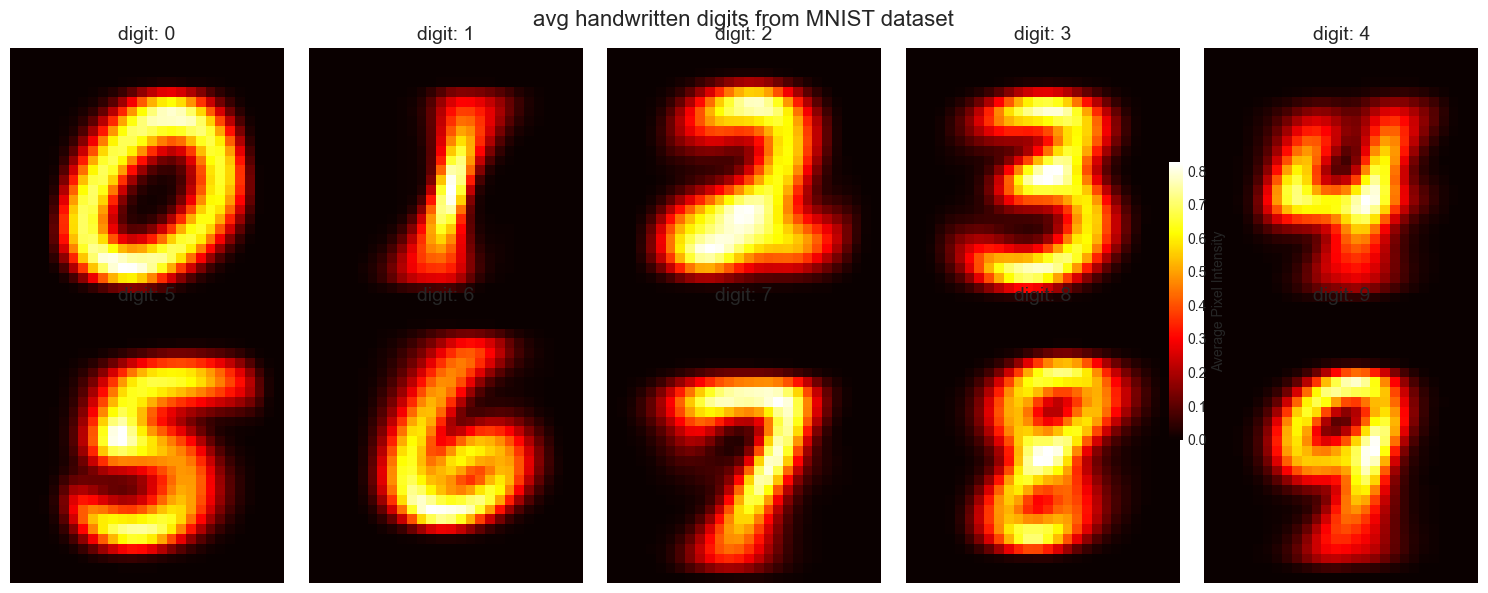

In [17]:
def compute_avg_digits(X: NDArray[np.float64], y: NDArray[np.int_]) -> Dict[int, NDArray[np.float64]]:
    avg_digits = {}
    for digit in range(10):
        samples = X[y == digit]
        avg_digits[digit] = np.mean(samples, axis=0)
    return avg_digits

avg_digits = compute_avg_digits(X, y)


#avg digit viz
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('avg handwritten digits from MNIST dataset', fontsize=16)

for dig in range(10):
    ax = axes[dig // 5, dig % 5]
    avg_img = avg_digits[dig].reshape(28, 28) #reshape to 28x28 pixels
    im = ax.imshow(avg_img, cmap='hot', interpolation='nearest')
    ax.set_title(f'digit: {dig}', fontsize=14)
    ax.axis('off')

plt.colorbar(im, ax=axes.ravel().tolist(), label='Average Pixel Intensity', shrink=0.6)
plt.tight_layout()
plt.savefig('01_average_digits.png', dpi=300, bbox_inches='tight')
plt.show()


## 1.2: distance metric between digits

distance matrix (euclidean distance between average digits):
      0     1     2     3     4     5     6     7     8     9
0  0.00  7.58  5.63  5.60  6.26  4.54  5.65  6.37  5.63  6.19
1  7.58  0.00  5.07  5.15  5.67  4.86  5.73  5.37  4.80  5.35
2  5.63  5.07  0.00  4.40  4.76  4.55  3.98  5.37  3.85  4.98
3  5.60  5.15  4.40  0.00  5.29  3.13  5.40  5.24  3.64  4.82
4  6.26  5.67  4.76  5.29  0.00  4.15  4.30  4.03  4.34  2.49
5  4.54  4.86  4.55  3.13  4.15  0.00  4.41  4.48  3.10  3.79
6  5.65  5.73  3.98  5.40  4.30  4.41  0.00  5.68  4.70  4.74
7  6.37  5.37  5.37  5.24  4.03  4.48  5.68  0.00  4.79  3.01
8  5.63  4.80  3.85  3.64  4.34  3.10  4.70  4.79  0.00  3.84
9  6.19  5.35  4.98  4.82  2.49  3.79  4.74  3.01  3.84  0.00


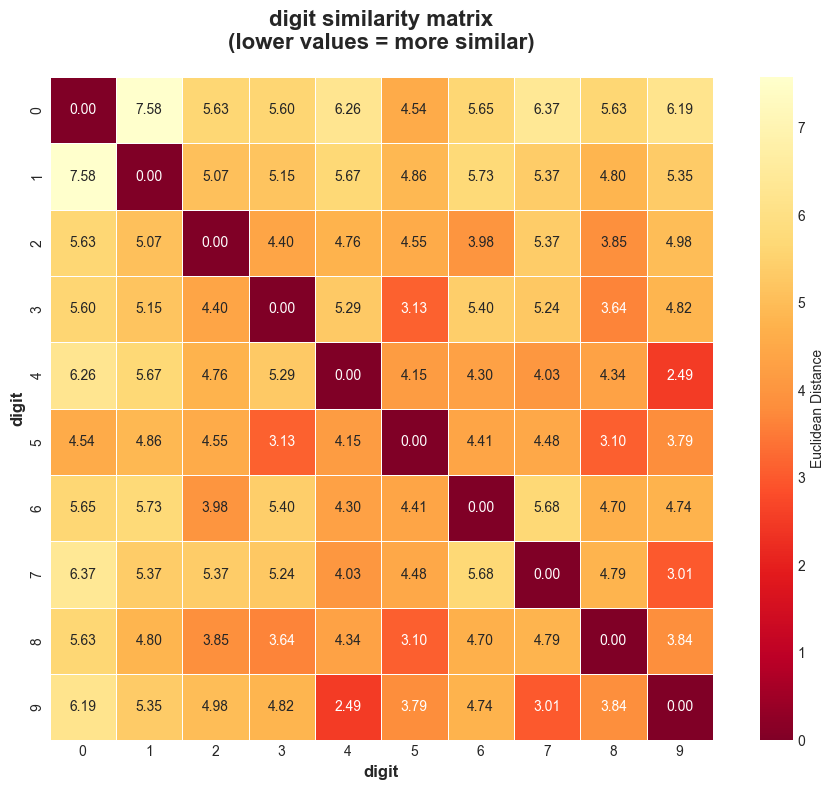


top 10 most similar digit pairs:
--------------------------------------------------
 1. digits 4 & 9: distance = 2.4905
 2. digits 7 & 9: distance = 3.0093
 3. digits 5 & 8: distance = 3.1029
 4. digits 3 & 5: distance = 3.1325
 5. digits 3 & 8: distance = 3.6441
 6. digits 5 & 9: distance = 3.7931
 7. digits 8 & 9: distance = 3.8379
 8. digits 2 & 8: distance = 3.8545
 9. digits 2 & 6: distance = 3.9807
10. digits 4 & 7: distance = 4.0301


In [20]:
avg_dig_matrix = np.array([avg_digits[i] for i in range(10)])

dist_matrix = squareform(pdist(avg_dig_matrix, metric='euclidean')) #compute pairwise euclidean distances

dist_df = pd.DataFrame(
    dist_matrix,
    index=[f'{i}' for i in range(10)],
    columns=[f'{i}' for i in range(10)]
)
print(f'distance matrix (euclidean distance between average digits):\n{dist_df.round(2)}')

#heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dist_df, annot=True, fmt='.2f', cmap='YlOrRd_r', 
            square=True, linewidths=0.5, cbar_kws={'label': 'Euclidean Distance'},
            vmin=0, ax=ax)
ax.set_title('digit similarity matrix\n(lower values = more similar)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('digit', fontsize=12, fontweight='bold')
ax.set_ylabel('digit', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('02_digit_distance_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


#most similar pairs 
similar_pairs: List[Tuple[int, int, float]] = []
for i in range(10):
    for j in range(i+1, 10):
        similar_pairs.append((i, j, dist_matrix[i, j]))

similar_pairs.sort(key=lambda x: x[2])

print("\ntop 10 most similar digit pairs:")
print("-" * 50)
for rank, (d1, d2, dist) in enumerate(similar_pairs[:10], 1):
    print(f"{rank:2d}. digits {d1} & {d2}: distance = {dist:.4f}")



## 1.3 pixel difference maps for most similar pairs

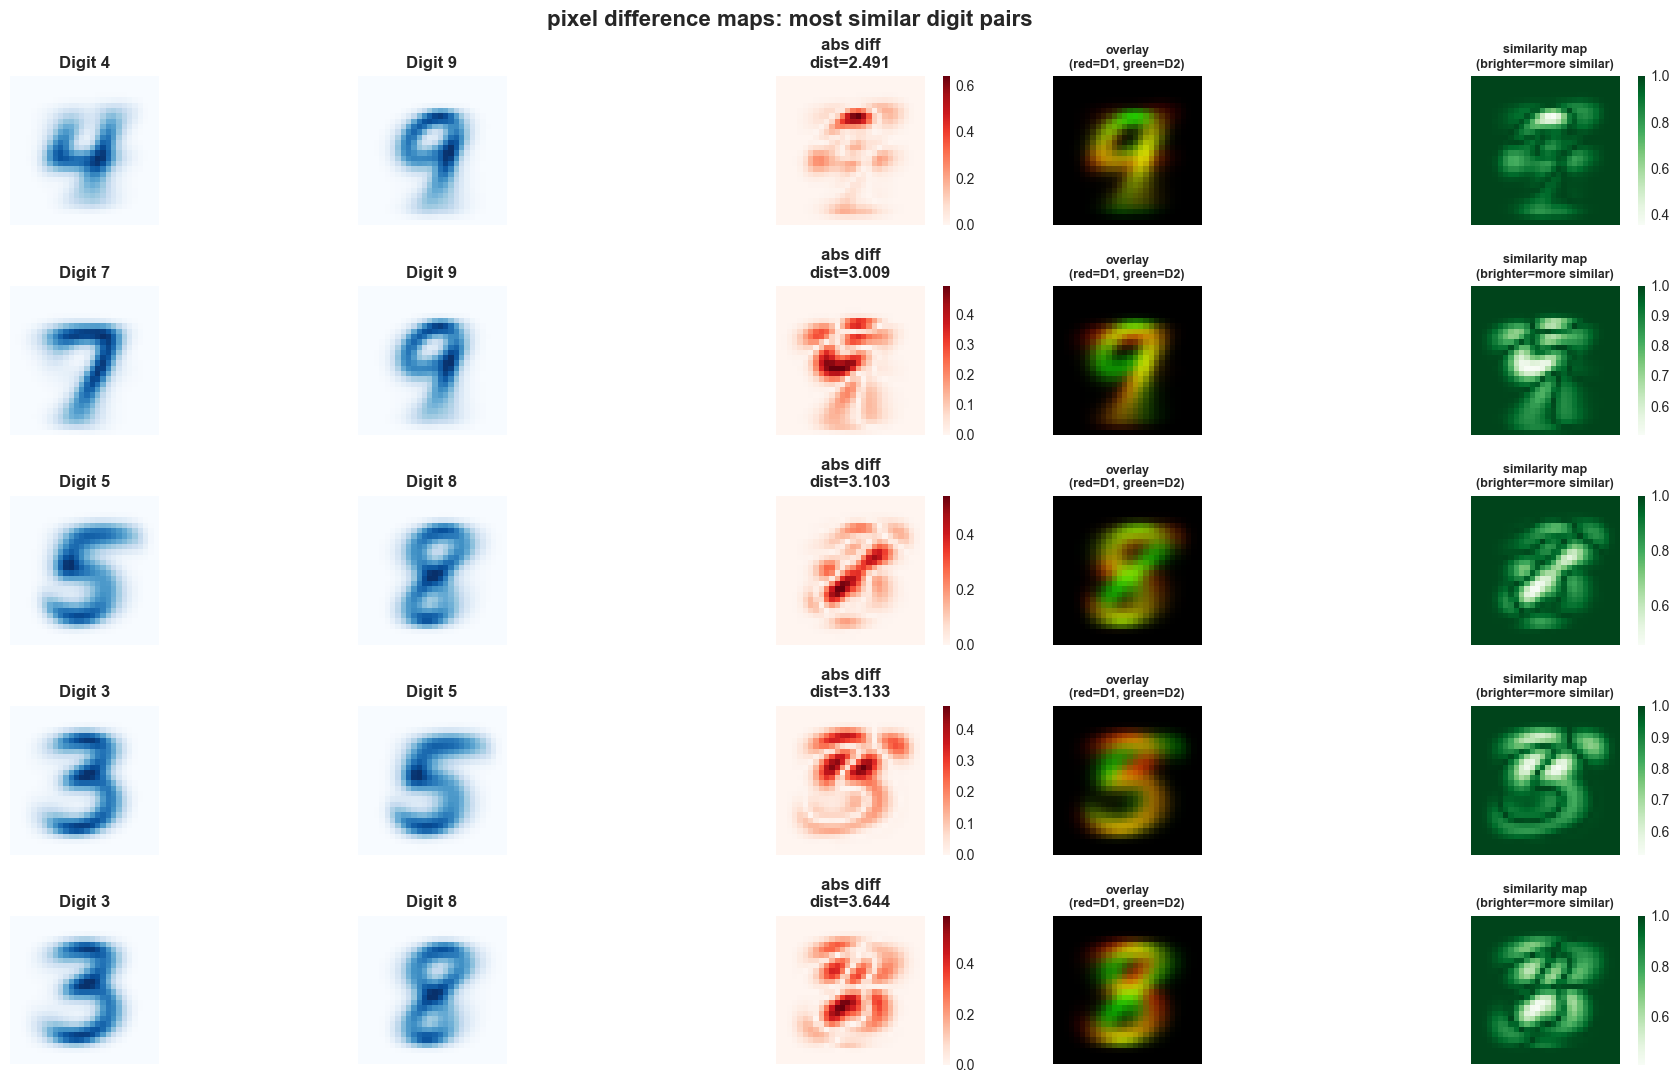

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(18, 11))
fig.suptitle('pixel difference maps: most similar digit pairs', 
             fontsize=16, fontweight='bold')

for idx, (d1, d2, dist) in enumerate(similar_pairs[:5]):
    #digit 1
    ax1 = axes[idx, 0]
    ax1.imshow(avg_digits[d1].reshape(28, 28), cmap='Blues', interpolation='nearest')
    ax1.set_title(f'Digit {d1}', fontweight='bold')
    ax1.axis('off')
    
    #digit 2
    ax2 = axes[idx, 1]
    ax2.imshow(avg_digits[d2].reshape(28, 28), cmap='Blues', interpolation='nearest')
    ax2.set_title(f'Digit {d2}', fontweight='bold')
    ax2.axis('off')
    
    #abs diff
    diff = np.abs(avg_digits[d1] - avg_digits[d2]).reshape(28, 28)
    ax3 = axes[idx, 2]
    im = ax3.imshow(diff, cmap='Reds', interpolation='nearest')
    ax3.set_title(f'abs diff\ndist={dist:.3f}', fontweight='bold')
    ax3.axis('off')
    plt.colorbar(im, ax=ax3, fraction=0.046)
    
    #overlay (show where they overlap)
    overlay = np.stack([avg_digits[d1].reshape(28, 28),
                       avg_digits[d2].reshape(28, 28),
                       np.zeros((28, 28))], axis=-1)
    ax4 = axes[idx, 3]
    ax4.imshow(overlay, interpolation='nearest')
    ax4.set_title('overlay\n(red=D1, green=D2)', fontweight='bold', fontsize=9)
    ax4.axis('off')
    
    #similarity map (inverted diff)
    similarity = 1 - diff
    ax5 = axes[idx, 4]
    im2 = ax5.imshow(similarity, cmap='Greens', interpolation='nearest')
    ax5.set_title('similarity map\n(brighter=more similar)', fontweight='bold', fontsize=9)
    ax5.axis('off')
    plt.colorbar(im2, ax=ax5, fraction=0.046)

plt.tight_layout()
plt.savefig('03_pixel_difference_maps.png', dpi=300, bbox_inches='tight')
plt.show()


# pixel importance: where do we look to recognize digits?

## 2.1: SD maps (shows var within each digit)

### NOTE: variation in '1', implies that people skew the digit, but they all overlap in the middle $\to$ illustrate with drawing on the board

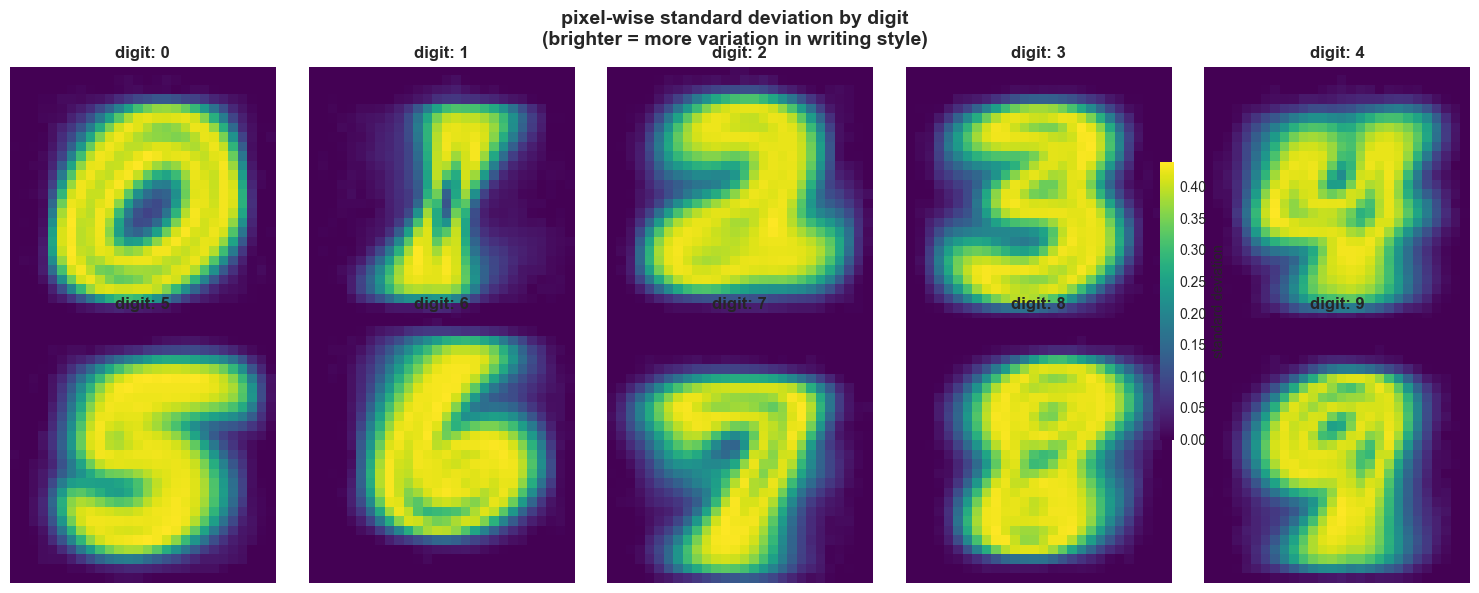

In [23]:
def compute_pixel_stats(X: NDArray[np.float64], y: NDArray[np.int_]) -> Dict[int, Dict[str, NDArray[np.float64]]]:
    stats = {}
    for dig in range(10):
        dig_samples = X[y == dig]
        stats[dig] = {
            'mean' : np.mean(dig_samples, axis=0),
            'std' : np.std(dig_samples, axis=0),
            'var' : np.var(dig_samples, axis=0)
        }
    return stats

pixel_stats = compute_pixel_stats(X, y)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('pixel-wise standard deviation by digit\n(brighter = more variation in writing style)', 
             fontsize=14, fontweight='bold')

for digit in range(10):
    ax = axes[digit // 5, digit % 5]
    std_map = pixel_stats[digit]['std'].reshape(28, 28)
    im = ax.imshow(std_map, cmap='viridis', interpolation='nearest')
    ax.set_title(f'digit: {digit}', fontsize=12, fontweight='bold')
    ax.axis('off')
    
plt.colorbar(im, ax=axes.ravel().tolist(), label='standard deviation', shrink=0.6)
plt.tight_layout()
plt.savefig('04_pixel_std_maps.png', dpi=300, bbox_inches='tight')
plt.show()


## 2.2: discriminative power heatmap

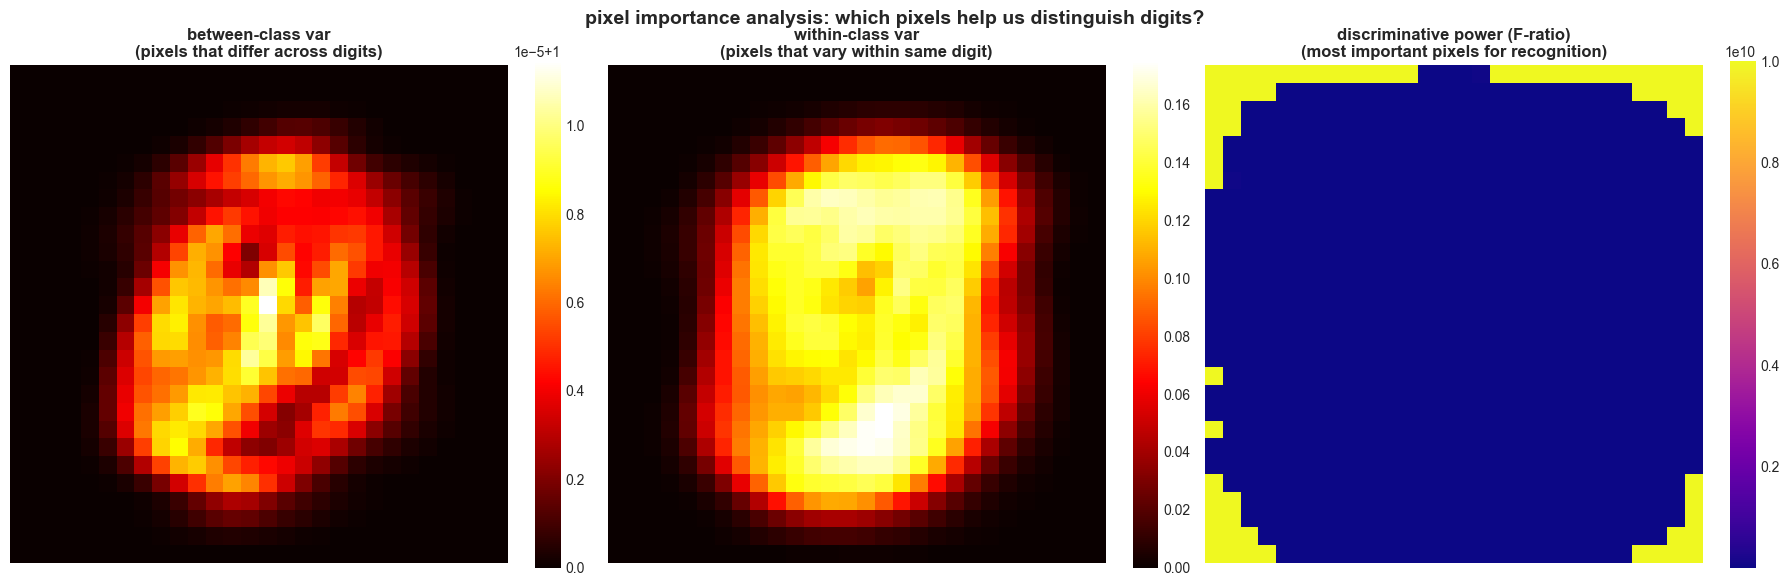

In [25]:
def compute_discriminative_power(X: NDArray[np.float64], y: NDArray[np.int_]) -> Dict[int, Dict[str, NDArray[np.float64]]]:
    overall_mean = np.mean(X, axis=0)

    between_class_var = np.zeros(X.shape[1]) #how much digit means differ from overall mean
    for dig in range(10):
        dig_samples = X[y == dig]
        dig_mean = np.mean(dig_samples, axis=0)
        n_samples = len(dig_samples)
        between_class_var += n_samples + (dig_mean - overall_mean)**2
    between_class_var /= len(X)

    within_class_var = np.zeros(X.shape[1]) #avg var within each class (digit)
    for dig in range(10):
        dig_samples = X[y == dig]
        within_class_var += np.var(dig_samples, axis=0)
    within_class_var /= 10

    #F-ratio: between-class / within-class (w/o div by 0, hence errstate)
    with np.errstate(divide='ignore', invalid='ignore'):
        disc_power = between_class_var / (within_class_var + 1e-10)
        disc_power = np.nan_to_num(disc_power)

    return disc_power, between_class_var, within_class_var

disc_power, between_class_var, within_class_var = compute_discriminative_power(X, y)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('pixel importance analysis: which pixels help us distinguish digits?', 
             fontsize=14, fontweight='bold')

#between-class variance
ax1 = axes[0]
im1 = ax1.imshow(between_class_var.reshape(28, 28), cmap='hot', interpolation='nearest')
ax1.set_title('between-class var\n(pixels that differ across digits)', fontweight='bold')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046)

#within-class variance
ax2 = axes[1]
im2 = ax2.imshow(within_class_var.reshape(28, 28), cmap='hot', interpolation='nearest')
ax2.set_title('within-class var\n(pixels that vary within same digit)', fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046)

#discriminative power (F-ratio)
ax3 = axes[2]
im3 = ax3.imshow(disc_power.reshape(28, 28), cmap='plasma', interpolation='nearest')
ax3.set_title('discriminative power (F-ratio)\n(most important pixels for recognition)', fontweight='bold')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, fraction=0.046)

plt.tight_layout()
plt.savefig('05_discriminative_power.png', dpi=300, bbox_inches='tight')
plt.show()


## 2.3: 'minimal' digits using only most important pixels

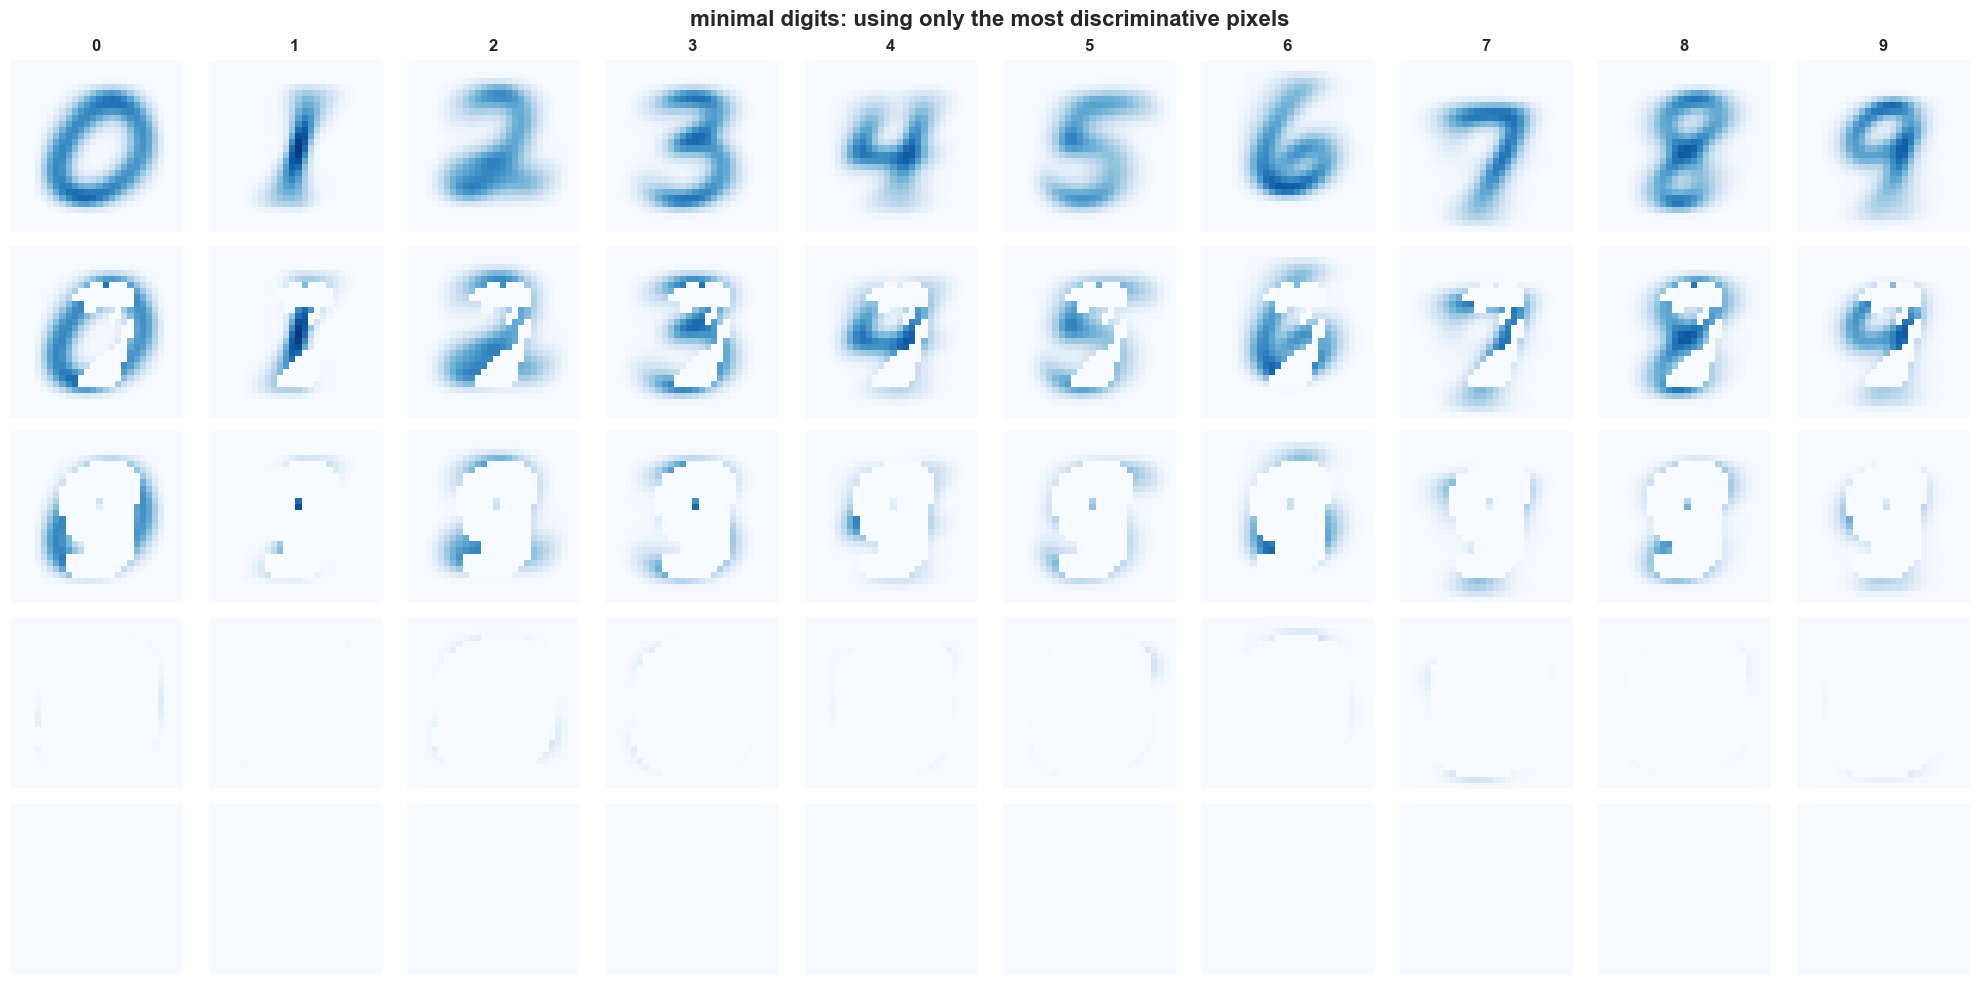

In [27]:
percentiles = [100, 90, 75, 50, 25]

fig, axes = plt.subplots(len(percentiles), 10, figsize=(20, 10))
fig.suptitle('minimal digits: using only the most discriminative pixels', 
             fontsize=16, fontweight='bold')

for p_idx, percentile in enumerate(percentiles):
    threshold = np.percentile(disc_power, 100 - percentile) #find threshold for this percentile
    mask = (disc_power >= threshold).reshape(28, 28)
    
    for digit in range(10):
        ax = axes[p_idx, digit]
        
        masked_digit: NDArray[np.float64] = avg_digits[digit].reshape(28, 28) * mask #apply mask to average digit
        
        ax.imshow(masked_digit, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
        
        if p_idx == 0:
            ax.set_title(f'{digit}', fontsize=12, fontweight='bold')
        if digit == 0:
            ax.set_ylabel(f'top {percentile}%\npixels', fontsize=10, fontweight='bold', rotation=0, 
                         ha='right', va='center')
        ax.axis('off')

plt.tight_layout()
plt.savefig('06_minimal_digits.png', dpi=300, bbox_inches='tight')
plt.show()


## 2.4: pixel importance by region

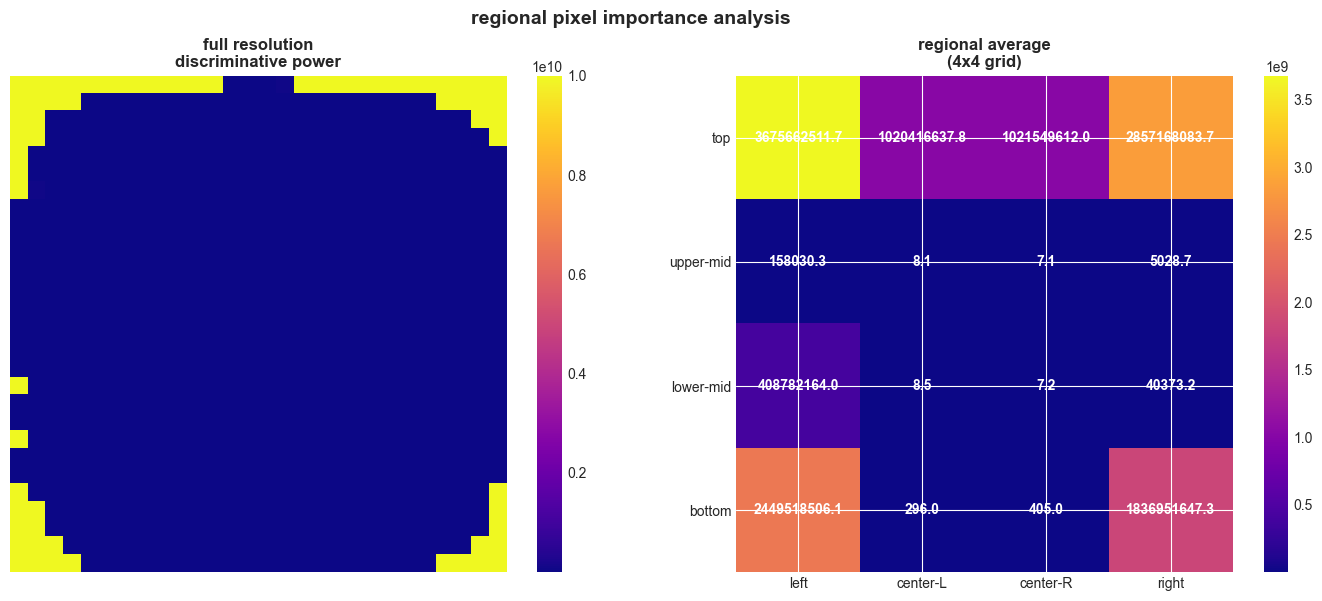

In [28]:
disc_power_2d = disc_power.reshape(28, 28) #divide 28x28 into 4x4 grid (7x7 regions)
region_importance = np.zeros((4, 4))

for i in range(4):
    for j in range(4):
        region = disc_power_2d[i*7:(i+1)*7, j*7:(j+1)*7]
        region_importance[i, j] = np.mean(region)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('regional pixel importance analysis', fontsize=14, fontweight='bold')

#full resolution
ax1 = axes[0]
im1 = ax1.imshow(disc_power_2d, cmap='plasma', interpolation='nearest')
ax1.set_title('full resolution\ndiscriminative power', fontweight='bold')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046)

#regional average
ax2 = axes[1]
im2 = ax2.imshow(region_importance, cmap='plasma', interpolation='nearest')
ax2.set_title('regional average\n(4x4 grid)', fontweight='bold')
ax2.set_xticks(range(4))
ax2.set_yticks(range(4))
ax2.set_xticklabels(['left', 'center-L', 'center-R', 'right'])
ax2.set_yticklabels(['top', 'upper-mid', 'lower-mid', 'bottom'])

#add values to cells
for i in range(4):
    for j in range(4):
        text = ax2.text(j, i, f'{region_importance[i, j]:.1f}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im2, ax=ax2, fraction=0.046)
plt.tight_layout()
plt.savefig('07_regional_importance.png', dpi=300, bbox_inches='tight')
plt.show()
